# 異方的相互作用を含む2次元Ising模型
横方向の交換相互作用$J_h$と縦方向の交換相互作用$J_v$とが区別される。

# Two-dimensional Ising model with anisotropic interactions
$J_h$ and $J_v$ denotes a coupling constant for horizontal and vertical direction respectively.
For convenience, we introduce the following normalized quantities, $K = T/J_h, R = J_v/J_h, h_n = h/J_h$, where $T$ is temperature and $h$ is an external field.

The critical temprature $T_c$ is given by
$$ \sinh \left(2J_h/T_c\right) \sinh \left(2J_v/T_c\right) = 1. $$
For the above notation, this formula is rewritten as
$$ \sinh \left(2/K_c\right) \sinh \left(2R/K_c\right) = 1, $$
where $K_c$ denotes a normalized critical temperature.

## 参考 Ref.
[Two dimensional Ising Model @Wikipedia](https://en.wikipedia.org/wiki/Ising_model#Two_dimensions)

In [19]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns

# the anisotropic Ising model　in two dimensions
# the exchange interactions J_h and J_v (horizontal and vertical direction)  

@jit
def initial_config(size_lat):
    "generate the initial spin configuration"
    return 2*(np.random.randint(0, 2, size=(size_lat, size_lat))-1/2)

@jit
def hamiltonian(arr_spin, rate_coupling, ex_field_normalized):
    "function to calculate a normalized Hamiltonian of the Ising model"
    n0, n1 = np.shape(arr_spin)
    energy_normalized = 0.0
    for i in range(-1,n0-1):
        for j in range(-1,n1-1):
            energy_normalized += -(arr_spin[i][j]*arr_spin[i][j+1] + rate_coupling*arr_spin[i][j]*arr_spin[i+1][j])
    energy_normalized += -ex_field_normalized*np.sum(arr_spin)
    return energy_normalized

@jit
def diff_hamiltonian(arr_spin, n0, n1, i, j, rate_coupling, ex_field_normalized):
    """
    function to calculate a difference of the normalized Hamiltonian
    this function does not flip the spin (no side-effect, spin_flip(arr_spin, i, j) plays its role)
    """
    return 2*(rate_coupling*(arr_spin[i][j]*arr_spin[i-1][j] + arr_spin[i][j]*arr_spin[-n0+i+1][j])
              + (arr_spin[i][j]*arr_spin[i][j-1] + arr_spin[i][j]*arr_spin[i][-n1+j+1])
              + ex_field_normalized*arr_spin[i][j])

@jit
def spin_flip(arr_spin, i, j):
    "subroutine to flip the spin we designated"
    arr_spin[i][j] = -arr_spin[i][j]

@jit
def update_config(arr_spin, n0, n1, energy_normalized, temp_normalized, rate_coupling, ex_field_normalized):
    """
    subroutine to update the spin configuration with the Metropolis method and output the noermalized energy
    side-effect：updating the spin configuration
    """
    for i in range(0,n0):
        for j in range(0,n1):
            diff_energy = diff_hamiltonian(arr_spin, n0, n1, i, j, rate_coupling, ex_field_normalized)
            if diff_energy <= 0:
                energy_normalized += diff_energy
                spin_flip(arr_spin, i, j)
            elif np.random.rand() < np.exp(-diff_energy/temp_normalized):
                energy_normalized += diff_energy
                spin_flip(arr_spin, i, j)
    return energy_normalized

def magnetization_plot(size_lat, temp_min, temp_max, rate_coupling, ex_field_normalized):
    """
    plot the magnetization per one site on a temperature-magnetization plane
    """
    num_update = 10000 # the maximum of the number of updates
    num_update_eq = 2000 # the number of updates to thermalize in num_update
    mag_lst =[] # the list of magnetizations per site for each temperature
    mag_sample = [] # the sample of magnetizations per cite measured in the equilibrium state
    temp_step = 100 # the number of steps of the temperature to measure the magnetization
    temp_lst = np.flip(np.linspace(temp_min, temp_max, temp_step)) # the list of temperature to plot
    
    arr_spin = initial_config(size_lat) # generate the initial spin configuration
    n0, n1 = np.shape(arr_spin)
    energy = hamiltonian(arr_spin, rate_coupling, ex_field_normalized) # energy at the initial spin configuration

    for temp_tmp in temp_lst:
        mag_sample = []
        # thermalize
        for i in range(0, num_update_eq):
            energy=update_config(arr_spin, n0, n1, energy, temp_tmp, rate_coupling, ex_field_normalized)
        # measure the magnetization in the equilibrium state
        for i in range(0, num_update - num_update_eq):
            energy=update_config(arr_spin, n0, n1, energy, temp_tmp, rate_coupling, ex_field_normalized)
            energy=update_config(arr_spin, n0, n1, energy, temp_tmp, rate_coupling, ex_field_normalized)
            mag_sample.append(np.sum(arr_spin)/len(arr_spin)**2)

        mag_lst.append(np.mean(mag_sample))
    
    # plot
    plt.plot(temp_lst, mag_lst)
    plt.grid(True)
    plt.ylabel("magnetization per cite")
    plt.xlabel("T / J_h")
    plt.xlim(round(temp_min,1), temp_max)
    plt.show()


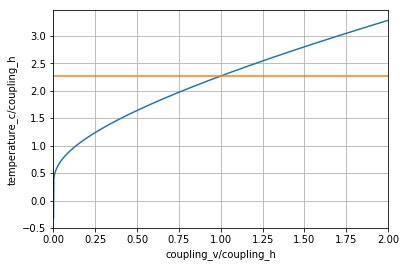

In [9]:
from scipy import optimize

def cri_temp(rate_coupling):
    return lambda k_c: np.sinh(2/k_c) * np.sinh(2*rate_coupling/k_c) - 1.0

lst_rate_coupling = np.linspace(0.001, 2.0, 1000)
lst_critical_temp = [optimize.newton(cri_temp(rate_coupling), 0.5) for rate_coupling in lst_rate_coupling]

temp_critical = 2/(np.log(1+np.sqrt(2)))
lst_critical_constant = [temp_critical for i in range(1000)]

# the critical temperature in the anisotropic Ising model (fixed to J_h = 1.0)
plt.plot(lst_rate_coupling, lst_critical_temp)
plt.plot(lst_rate_coupling, lst_critical_constant)
plt.grid(True)
plt.ylabel("temperature_c/coupling_h")
plt.xlabel("coupling_v/coupling_h")
plt.xlim(0, 2.0)
plt.show()

30.0
0.017447199265381085


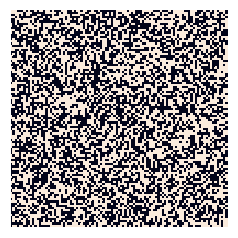

In [10]:
a=initial_config(99)
a0, a1 = np.shape(a)
e=hamiltonian(a, 1, 0.0)
print(e)
print(np.sum(a)/len(a)**2)

plt.figure()
sns.heatmap(a, cbar=False, square=True, xticklabels=False, yticklabels=False)

mag: 0.008264462809917356
mag: -0.006223854708703193
mag: -0.00030609121518212427
mag: -0.007448219569431691
mag: -0.002346699316396286
mag: 0.0007142128354249566
mag: 0.008060401999795939
mag: -0.0013263952657892053
mag: -0.004183246607489032
mag: -0.0005101520253035404
CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.11 s


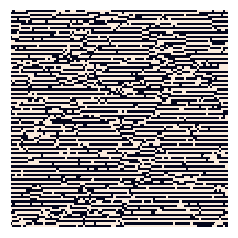

In [13]:
%%time
t_c = 2.0/np.log(np.sqrt(2.0)+1)
for i in range(0,1000):
    e=update_config(a, a0, a1, e, t_c, -1.0, 0.0)
    if i%100==0 :
        print("mag: " + str(np.sum(a)/len(a)**2))
plt.figure()
sns.heatmap(a, cbar=False, vmax=1, vmin=-1, square=True, xticklabels=False, yticklabels=False)

vertical/horizontal: 0.5


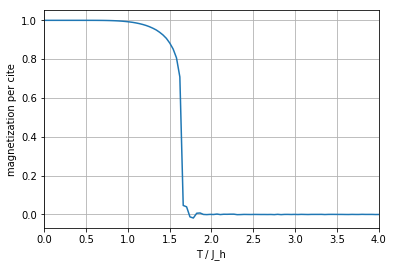

CPU times: user 6min 46s, sys: 992 ms, total: 6min 47s
Wall time: 6min 44s


In [24]:
%%time
rate = 0.5
print("vertical/horizontal: " + str(rate))
magnetization_plot(64, 0.01, 4.0, rate, 0)